In [3]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
#import pandas as pd
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
import warnings; warnings.simplefilter('ignore')
from tsplot import tsplot

# Téma 5: ARIMA(p,d,q)

Nyní se podíváme blíže na modely ARIMA (AutoRegressive Integrated Moving Average). Zde máme hned tři parametry:

- p - řád autoregresní části (AR)
- q - řád modelu klouzavých průměrů (MA)
- d - řád differencování

Diferencováním řady se snažíme odstranit z ní trend nebo náhodnou procházku. To lze nejlépe vidět na příkladu náhodné procházky, která vlastně vzniká integrováním náhodně generovaných kroků z množiny {-1, 1} (potenciálně jiných, ale to neřešme). Zkusme $d\in\{0,1,2\}$, co uvidíme v grafu zde a níže.

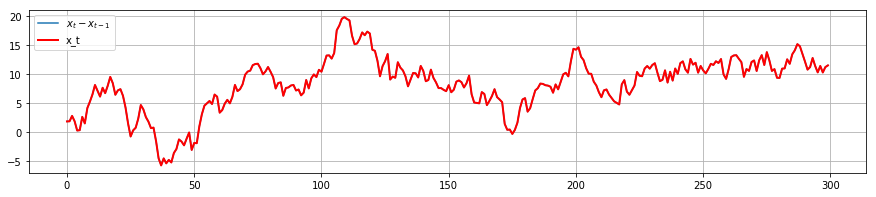

In [54]:
ndat = 300
d = 0
np.random.seed(123)  # pro stejná data při různých nastaveních
x_tmp = np.random.randint(-1, 2, size=ndat) + np.random.normal(size=ndat)
x = np.cumsum(x_tmp)
model = sm.tsa.ARIMA(x, order=(0,d,0))
plt.figure(figsize=(15,3))
plt.plot(np.arange(d,ndat), model.endog, label=r'$x_t - x_{t-1}$')
plt.plot(x, 'r', lw=2, label='x_t')
plt.legend()
plt.show()

Zkusme se podívat na syrová data `x` a na diferencovaná v `model.endog`. **Zjištění: Časové řady s trendem nebo náhodnou procházkou jsou vždy silně pozitivně autokorelované.** To, co vypadá jako význačná charakteristika pro AR proces je ve skutečnosti znamení poddiferencovanosti - diferencováním ji odstraníme a v uvedeném příkladu se dostaneme k ryze náhodnému procesu - procházce. Přediferencováním dostaneme opak - MA charakteristiku. Z toho plyne následující: **AR charakteristika může značit poddiferencovanost časové řady, zatímco MA charakteristika přediferencovanost.** Jedno z užitečných pravidel je, že $d\leq 2$, přičemž druhé diference jsou v praxi relativně řídké. **A při $d=2$ nepoužíváme v ARIMA modelu konstantu $c$.** Výjimky jsou řídké.

Řád diferencování:  0


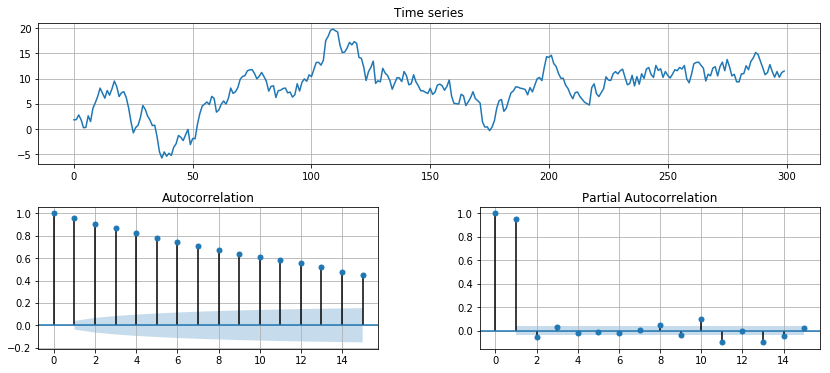

In [56]:
print('Řád diferencování: ', d)
tsplot(model.endog)   ### x nebo model.endog

## Běžné ARIMA modely

- ARIMA(0,0,0)+c - konstantní model
- ARIMA(0,1,0) - model náhodné procházky (viz výše)
- ARIMA(0,1,0)+c - náhodná procházka s driftem
- ARIMA(1,0,0)+c - AR(1) model
- ARIMA(2,0,0)+c - AR(2) model
- ARIMA(1,1,0)+c - AR(1) model na jednou diferencovaných datech
- ARIMA(2,1,0)+c - AR(2) model na jednou diferencovaných datech
- ARIMA(0,1,1) - jednoduché exponenciální vyhlazování - MA(1) model na diferencovaných datech
- ARIMA(0,1,1)+c - jednoduché exponenciální vyhlazování - MA(1) na diferencovaných datech - s konst. lin. trendem
- ARIMA(1,1,2) - lineární exponenciální vyhlazování s tlumeným trendem
- ARIMA(0,2,2) - zobecněné lineární exponenciální vyhlazování

Zkuste sami identifikovat chování ARIMA(1,0,0)+c kde $c$ je drift (to je nápověda):

1. $\phi_1 = 0$
2. $\phi_1 = 1, c=0$
3. $\phi_1 = 1, c \ne 0$
4. $\phi_1 < 0$

(odpovědi: bílý šum, náhodná procházka, náhodná procházka s driftem, řada oscilující mezi kladnými a zápornými hodnotami).

## Obecná pravidla (se spoustou výjimek :))

- $d \leq 2$ - spíše zřídka potřebujeme druhé diference a třetí už jsou vyloženě výjimečné. 
- $d = 2 \Rightarrow$ nepoužíváme skoro nikdy konstantu $c$ v modelu.
- zpravidla volíme $p=0$ nebo $q=0$. Směsové modely jsou spíše v menšině, ale ve fyzikálních systémech jsou často ARIMA(p,0,p-1).
- $p+q \leq 3$ - složitější modely jsou řídké.
- obecně volíme co nejjednodušší modely.
- modely můžeme porovnat kritérii AIC, BIC.

![arima](img/ARIMA.png)

# Operátor zpoždění

Operátor zpoždění ([lag operator, backshift operator](https://en.wikipedia.org/wiki/Lag_operator)) značíme $B$ nebo $L$ a používáme pro zjednodušení zápisu:

$$
\begin{aligned}
BX_t &= X_{t-1} \\
B^{-1}X_t &= X_{t+1} \\
B^k X_t &= \underbrace{B\cdot B \cdots B}_{k\times}X_t = X_{t-k}.
\end{aligned}
$$

Díky tomu můžeme zavádět **AR(p)** proces takto:

$$
\begin{aligned}
X_t &= \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t \\
&\Longrightarrow \qquad 
\varepsilon_t = X_t - \phi_1 B^1 X_{t-1} - \ldots - \phi_p B^p X_{t-p}
= \left( 1 - \sum_{i=1}^p \phi_i B^i\right) X_t.
\end{aligned}
$$

Analogicky pro **MA(q)** máme

$$
X_t = \left( 1 + \sum_{i=1}^q \theta_i B^i \right) \varepsilon_t,
$$

z čehož pro **ARMA(p,q)** bez konstanty $c$ plyne

$$
\Phi X_t = \Theta \varepsilon_t, \qquad\text{kde}\qquad
\Phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\Theta = 1+\sum_{i=1}^q \theta_i B^i.
$$

### Operátor diference $\nabla$

$$
\begin{aligned}
\nabla X_t &= X_t - X_{t-1} = (1-B) X_t, \\
\nabla^2 X_t &= \nabla(\nabla X_t) = \nabla X_t - \nabla X_{t-1} = (1-B) \nabla X_t \\
&= (1-B)^2 X_t,\\
\nabla^k X_t &= (1-B)^k X_t.
\end{aligned}
$$

Díky všem uvedeným operátorům můžeme definovat **ARIMA(p,d,q)** model následovně:

$$
\mathbf{\phi} X_t = \mathbf\theta \varepsilon_t, \qquad\text{kde}\qquad
\mathbf\phi=1-\sum_{i=1}^p \phi_i B^i \qquad\text{a}\qquad
\mathbf\theta = 1+\sum_{i=1}^q \theta_i B^i,
$$

popřípadě s konstantou $c$

$$
\mathbf\phi (1-B)^d X_t = c + \mathbf\theta \varepsilon_t.
$$

### K čemu jsou operátory dobré?

- umožňují snadný zápis charakteristických polynomů při vyšetřování stacionarity AR a invertibility MA procesu.
- jde s nimi dělat různá algebraická kouzla díky komutativitě $B(\beta X_t) = \beta BX_t$, distributivitě atd.

# Modely SARIMA(p,d,q)(P,D,Q)s

Pokud časová řada vykazuje sezónnost, tj. cyklické opakování určitého vývoje, ARIMA modely stále nebudou stačit. Konkrétně říkáme, že časová řada bez trendu vykazuje sezónnost s periodou $s$, pokud

$$
\mathbb{E}[X_t]=\mathbb{E}[X_{t-s}].
$$

V časových řadách se sezónností je situace komplikovanější, neboť tam je sezónnost dalším důvodem nestacionarity.

Typicky předpokládáme, že perioda $s$ je konstantní, nicméně to samozřejmě není úplná pravda. Data navíc mohou mít více period, např. týdenní a měsíční.

## Přiblížení stacionaritě (d, D)

Z teorie ARIMA modelů už víme, že ke stacionaritě nás posune diferencování, tedy vytvoření nové řady z rozdílů po sobě jdoucích hodnot,

$$
\nabla X_t = (1-B) X_t = X_t - X_{t-1}.
$$

Toto můžeme dělat $d$ krát, většinou maximálně dvakrát, $\nabla^2 X_t$.

Analogicky můžeme přibližně zestacionárnit i časovou řadu se sezónností s periodou $s$,

$$
\nabla_s X_t = (1-B^s) X_t = X_t - X_{t-s}.
$$

Pozor, index je dolní. Opět můžeme diferencovat víckrát, $\nabla_s^D$, zpravidla maximálně jednou. Spojíme-li to dohromady, dostaneme diferencování

$$
\nabla_s^D \nabla^d X_t.
$$

Z AR, MA, ARMA a ARIMA víme, že modelovat závislosti dat v řadě můžeme do libovolné hloubky. Teoreticky bychom mohli sezónnost zkusit postihnout dostatečně složitým modelem, sahajícím pro veličiny hlouběji v minulosti. To je ovšem v rozporu s požadavkem na jednoduchost modelů. Např. při $s=12$ bychom závislost tří po sobě jdoucích sezón modelovali 36 AR  nebo MA koeficienty! Mnohem jednodušší je uvažovat běžný a sezónní vývoj zvlášť a použít multiplikativní model SARIMA(p,d,q)(P,D,Q)s:

$$
\Phi_P(B^s) \phi_p(B) \nabla_s^D \nabla^d X_t = \theta_q(B) \Theta_Q (B^s)\varepsilon_t
$$

kde

- $\Phi_P(B^s) = (1-\Phi_1 B^s - \ldots - \Phi_p B^{sP})$ je sezónní AR operátor řádu $P$,
- $\phi_p = (1 - \phi_1 B - \ldots - \phi_p B^p)$ je běžný AR operátor řádu $p$,
- $\nabla_s^D = (1-B^s)^D$ je operátor sezónní diference řádu $D$,
- $\nabla^d = (1-B)^d$ je operátor běžné diference řádu $d$,
- $\Theta_Q(B^s) = (1 + \Theta_1 B^s + \ldots + \Theta_Q B^{sQ})$ je sezónní MA operátor řádu $Q$,
- $\theta_q(B) = (1 + \theta_1 B + \ldots + \theta_q B^{q})$ je běžný MA operátor řádu $q$,

Zcela patrný je zde (poněkud naivní) předpoklad, že i sezóny se vyvíjí podle neměnného modelu.

## Příklad - počty pasažérů

Podívejme se na příklad s počty pasažérů, který jsme si představili na první přednášce. Na grafu vidíme jednoznačně trend i sezónnost. Nejlepší nafitovaný model je SARIMA(3,1,0)(1,2,1)12. Na spodním grafu je vidět i predikce na (nesmyslných) 100 kroků dopředu (tj. 1 na každý měsíc).

![acf](img/passengers-acf.png)

![arima](img/passengers-arima.png)

A ještě rezidua:

![arima](img/passengers-resid.png)